# **_Import Libraries and Read Data_**


In [102]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time

# Change format
pd.set_option('display.float_format', '{:.4f}'.format)

# Read Data
df_movies = pd.read_csv('Datasets/netflix_titles.csv')

# Display Movie
df_movies.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


# **_Preprocessing_**


## _Data Cleaning_


### _Remove Irrelevent Columns_


In [103]:
# Remove show_id, title and description
df_movies = df_movies.drop(['show_id','title', 'date_added','description'], axis = 1)

In [104]:
df_movies.head(3)

,type,director,cast,country,release_year,rating,duration,listed_in
0,Movie,Kirsten Johnson,NaN,United States,2020,PG-13,90 min,Documentaries
1,TV Show,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries"
2,TV Show,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."


### _Handle Missing_


In [105]:
# Check missing values
df_movies.isnull().sum()

type               0
director        2634
cast             825
country          831
release_year       0
rating             4
duration           3
listed_in          0
dtype: int64

In [106]:
# Remove rows that have null in cast
df_movies = df_movies.dropna(subset = ['director'])
df_movies = df_movies.dropna(subset = ['country'])
df_movies = df_movies.dropna(subset = ['cast'])
df_movies = df_movies.dropna(subset = ['rating'])
df_movies = df_movies.dropna(subset = ['duration'])
# df_movies = df_movies.fillna({'director': 'Unknown', 'country': 'Unknown', 'cast': 'Unknown', 'rating': 'Unknown', 'duration': '0 min'})

df_movies.isnull().sum()

type            0
director        0
cast            0
country         0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64

In [107]:
# Check shape
df_movies.shape

(5332, 8)

### _Handling Outliers_


In [108]:
# Describe dataframe
df_movies.describe()

,release_year
count,5332.0000
mean,2012.7421
std,9.6258
min,1942.0000
25%,2011.0000
50%,2016.0000
75%,2018.0000
max,2021.0000


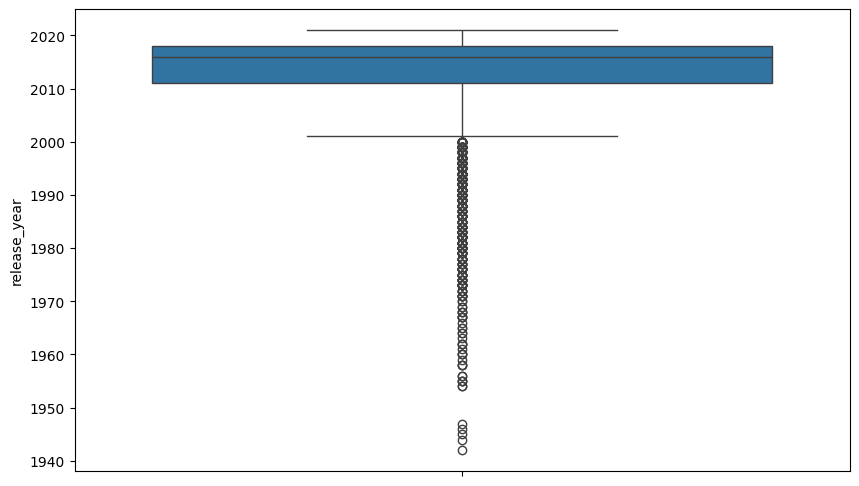

In [109]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_movies['release_year'])
plt.show()

In [110]:
# Calculate quartile range
Q1 = df_movies['release_year'].quantile(0.25)
Q3 = df_movies['release_year'].quantile(0.75)
IQR = Q3 - Q1

# Calculate mild bounderies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calculate extreme bounderies
lower_extreme_bound = Q1 - 3 * IQR
upper_extreme_bound = Q3 + 3 * IQR

# Drop Extereme outliers
df_movies = df_movies[(df_movies['release_year'] >= lower_extreme_bound) & (df_movies['release_year'] <= upper_extreme_bound)]

# Cap outliers
df_movies['release_year'] = np.where(df_movies['release_year'] > upper_bound, upper_bound,
        np.where(df_movies['release_year'] < lower_bound,lower_bound,df_movies['release_year']))

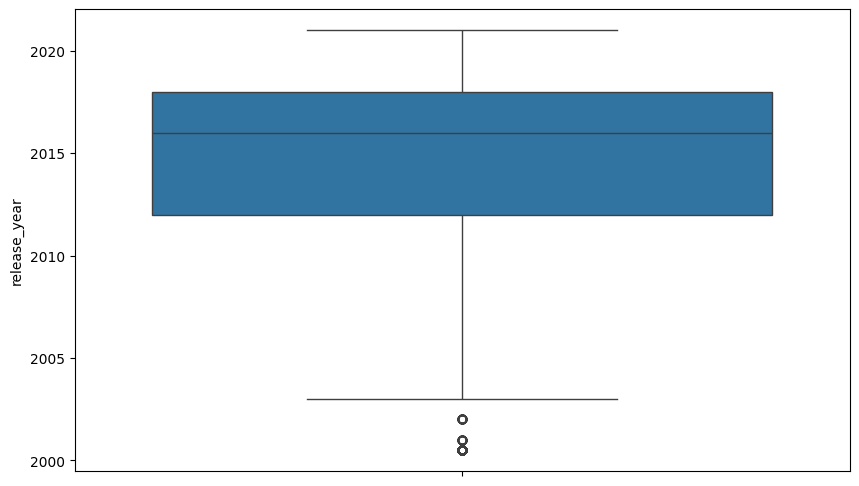

In [111]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_movies['release_year'])
plt.show()

In [112]:
df_movies.shape

(5118, 8)

### _Handling Duplicates_


In [113]:
# Check duplicates
df_movies.duplicated().sum()

np.int64(9)

In [114]:
# Drop Duplicates
df_movies = df_movies.drop_duplicates()

# Show number of duplicates
df_movies.duplicated().sum()

np.int64(0)

### _Handling Imbalance_


Text(0, 0.5, 'Count')

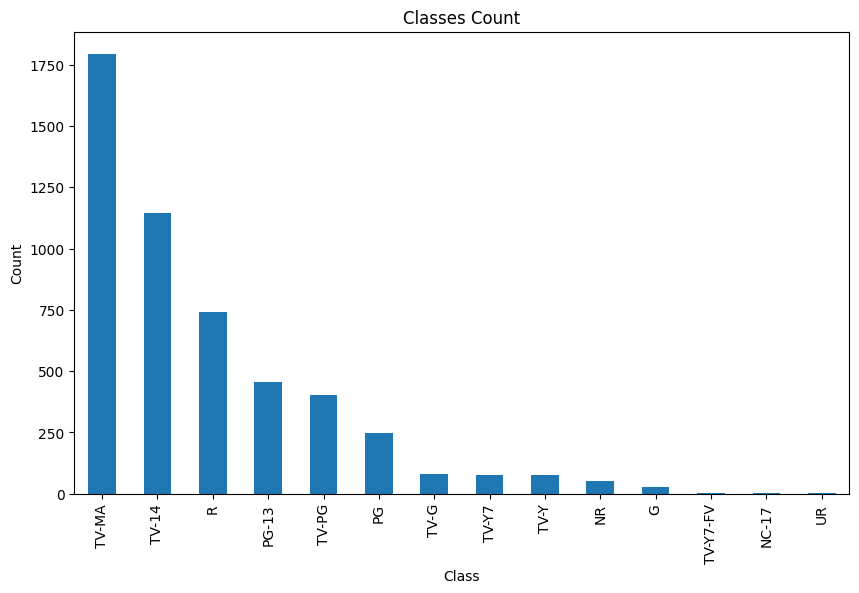

In [115]:
# Show classes
plt.figure(figsize = (10,6))
df_movies['rating'].value_counts().plot(kind = 'bar')
plt.title("Classes Count")
plt.xlabel('Class')
plt.ylabel('Count')

In [116]:
# Check number of samples
df_movies['rating'].value_counts()

rating
TV-MA       1795
TV-14       1147
R            741
PG-13        455
TV-PG        402
PG           246
TV-G          82
TV-Y7         76
TV-Y          76
NR            53
G             29
TV-Y7-FV       3
NC-17          2
UR             2
Name: count, dtype: int64

In [117]:
# Store categorical data
categorical_columns = [0,1,2,3,5,6]

# Split target and features
x = df_movies.drop('rating', axis = 1)
y = df_movies['rating']

# Initialize SMOTENC
smote_nc = SMOTENC(
    categorical_features = categorical_columns,
    random_state = 42,
    k_neighbors = 1
)

# Fit into data
X_resampled, y_resampled = smote_nc.fit_resample(x, y)

# Combine data
df_movies = pd.concat([X_resampled, y_resampled], axis = 1)

# Display dataframe
df_movies.shape

(25130, 8)

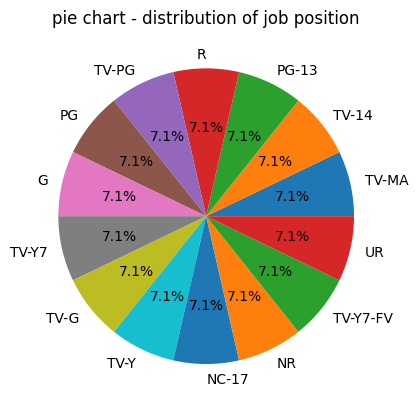

In [118]:
position_count = df_movies['rating'].value_counts()
plt.pie(position_count , labels=position_count.index, autopct='%1.1f%%')
plt.title('pie chart - distribution of job position')
plt.show()

In [119]:
# Check number of samples
df_movies['rating'].value_counts()

rating
TV-MA       1795
TV-14       1795
PG-13       1795
R           1795
TV-PG       1795
PG          1795
G           1795
TV-Y7       1795
TV-G        1795
TV-Y        1795
NC-17       1795
NR          1795
TV-Y7-FV    1795
UR          1795
Name: count, dtype: int64

## _Split Data into Train and Test_


In [120]:
# Divide data to input and output
inputs = df_movies.drop('rating', axis=1)
outputs = df_movies['rating']

# Split data into train and test
train_input, test_input, train_output, test_output = train_test_split(inputs, outputs, test_size = 0.2, random_state = 47)

## _Encoding_


In [121]:
# Check unique values
train_input.nunique()

type               2
director        3388
cast            4314
country          520
release_year    9805
duration         187
listed_in        292
dtype: int64

### _One Hot Encoding_


In [122]:
# Set columns trasfromers
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')

# Assign new values to dataframe
train_encoded = ct.fit_transform(train_input)
test_encoded = ct.transform(test_input)

# Get encoded column names
encoded_cols = ct.named_transformers_['encoder'].get_feature_names_out(['type'])

# Get remainder column names
remainder_cols = [col for i, col in enumerate(train_input.columns) if i not in [0]]

# Combine them
all_cols = list(encoded_cols) + remainder_cols

# Create dataframe with columns name (encoder -> give an numpy array not a df)
train_input = pd.DataFrame(train_encoded, columns=all_cols)
test_input = pd.DataFrame(test_encoded, columns=all_cols)

# Display dataframe
train_input.head(3)

,type_Movie,type_TV Show,director,cast,country,release_year,duration,listed_in
0,1.0000,0.0000,Zach Clark,"Addison Timlin, Ally Sheedy, Keith Poulson, Pe...",United States,2016.0000,91 min,"Comedies, Dramas, Independent Movies"
1,1.0000,0.0000,Ari Sandel,"Jeremy Ray Taylor, Madison Iseman, Caleel Harr...","United States, United Kingdom",2018.0000,90 min,"Children & Family Movies, Comedies"
2,1.0000,0.0000,Abhijit Panse,"Nawazuddin Siddiqui, Amrita Rao, Rajeev Panday...",India,2018.2833,135 min,"Dramas, International Movies"


### _Target Encoding_


In [123]:
# Reset indexes to ensure alignment before Target Encoding
# To avoid Mismatch between rows
train_input = train_input.reset_index(drop=True)
train_output = train_output.reset_index(drop=True)
test_input = test_input.reset_index(drop=True)
test_output = test_output.reset_index(drop=True)

# Set columns to target encoding
encoder = ce.TargetEncoder(cols=['director', 'cast', 'country', 'duration', 'listed_in'])

# Fit and tranfrom train data
train_input = encoder.fit_transform(train_input,train_output)

# Transform test data ( not fit cause we don't want it to see the target )
test_input = encoder.transform(test_input)

# Display dataframe
train_input.head(3)

,type_Movie,type_TV Show,director,cast,country,release_year,duration,listed_in
0,1.0000,0.0000,5.9249,5.9249,6.1148,2016.0000,5.0618,5.4720
1,1.0000,0.0000,4.5695,4.5810,4.0021,2018.0000,5.1618,8.5582
2,1.0000,0.0000,6.4393,6.4393,7.3838,2018.2833,5.7385,6.1132


## _Scaling_


### _Handling Types_


In [124]:
# Check info
train_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20104 entries, 0 to 20103
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type_Movie    20104 non-null  object 
 1   type_TV Show  20104 non-null  object 
 2   director      20104 non-null  float64
 3   cast          20104 non-null  float64
 4   country       20104 non-null  float64
 5   release_year  20104 non-null  object 
 6   duration      20104 non-null  float64
 7   listed_in     20104 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.2+ MB


In [125]:
# Change type of all feature to be numer
train_input = train_input.apply(pd.to_numeric, errors='coerce')
test_input = test_input.apply(pd.to_numeric, errors='coerce')

In [126]:
# Check info
train_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20104 entries, 0 to 20103
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type_Movie    20104 non-null  float64
 1   type_TV Show  20104 non-null  float64
 2   director      20104 non-null  float64
 3   cast          20104 non-null  float64
 4   country       20104 non-null  float64
 5   release_year  20104 non-null  float64
 6   duration      20104 non-null  float64
 7   listed_in     20104 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


In [127]:
# Describe dataframe
train_input.describe()

,type_Movie,type_TV Show,director,cast,country,release_year,duration,listed_in
count,20104.0000,20104.0000,20104.0000,20104.0000,20104.0000,20104.0000,20104.0000,20104.0000
mean,0.9807,0.0193,6.6146,6.6257,6.5410,2013.6284,6.4954,6.5365
std,0.1378,0.1378,3.6170,3.6074,2.4043,5.1025,2.8847,2.5797
min,0.0000,0.0000,0.0000,0.0000,0.0036,2000.5000,1.0069,0.1800
25%,1.0000,0.0000,5.1860,5.5674,6.1148,2011.9807,4.8323,4.8901
50%,1.0000,0.0000,6.5358,6.5754,6.1148,2014.1760,5.7649,6.6630
75%,1.0000,0.0000,9.0901,8.8681,7.3838,2017.0000,8.1730,8.5582
max,1.0000,1.0000,12.9930,13.0000,12.7823,2021.0000,12.0000,11.7812


### _Handling Scaling_


In [128]:
# Create standard scaler
sc = StandardScaler()

# Columns that will be scaled
cols_to_scale = ['release_year']

# Fit and transform train data
# fit  --> calculate mean , sd from traing set only 
#transform implement it on train_input only 

train_input[cols_to_scale] = pd.DataFrame(
    sc.fit_transform(train_input[cols_to_scale]),
    columns=cols_to_scale,
    index=train_input.index
)

# Transform test data
test_input[cols_to_scale] = pd.DataFrame(
    sc.transform(test_input[cols_to_scale]),
    columns=cols_to_scale,
    index=test_input.index
)

# Display train data
train_input.head(3)

,type_Movie,type_TV Show,director,cast,country,release_year,duration,listed_in
0,1.0000,0.0000,5.9249,5.9249,6.1148,0.4648,5.0618,5.4720
1,1.0000,0.0000,4.5695,4.5810,4.0021,0.8568,5.1618,8.5582
2,1.0000,0.0000,6.4393,6.4393,7.3838,0.9123,5.7385,6.1132


# ***K Nearest Neighbar***

## *Modling*

In [129]:
# Select best k
best_k = 1
best_accuracy = 0
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_input, train_output)
    predicted = knn.predict(test_input)
    acc = accuracy_score(test_output, predicted)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_k = k

# Create KNN model with 10 neighbars
knn = KNeighborsClassifier(
    n_neighbors = best_k,
    weights='uniform',
    metric='euclidean'
)

# Fit model into data
knn.fit(train_input, train_output)

# Predit data
predicted = knn.predict(test_input)

# Evaluate model
print("Accuracy:", accuracy_score(test_output, predicted))

Accuracy: 0.9130521289295662


## *Evaluation*

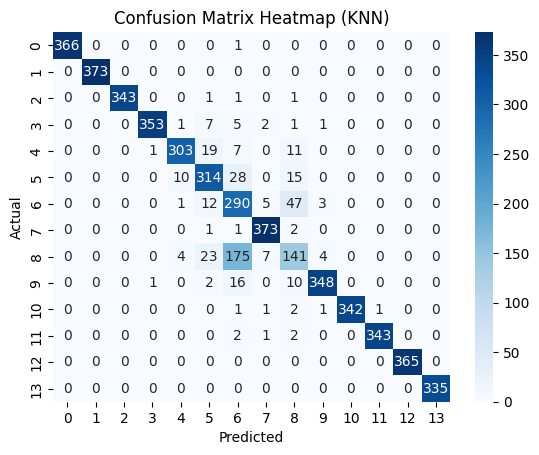

In [130]:
cm = confusion_matrix(test_output,predicted)

# Display it as heat map
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap (KNN)")
plt.show()

# ***Naive Bayes***

## *Modling*

In [133]:
# Create gaussian model
nb = GaussianNB()

# Fit gaussian model
nb.fit(train_input, train_output)

# predict values
predicted2 = nb.predict(test_input)
# Accuracy
print("Accuracy:", accuracy_score(test_output, predicted2))

Accuracy: 0.5923199363310784


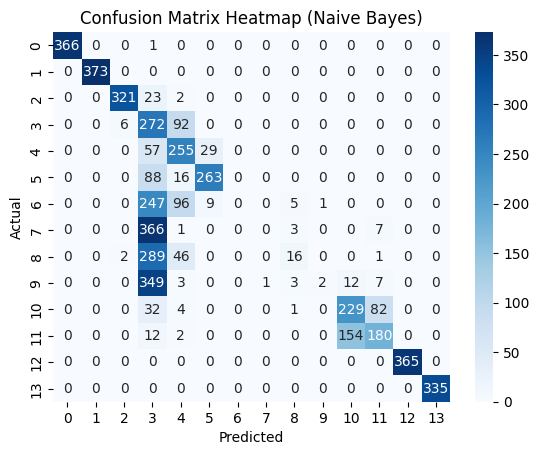

In [134]:
cm = confusion_matrix(test_output,predicted2)

# Display it as heat map
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap (Naive Bayes)")
plt.show()

# ***Comparison***

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


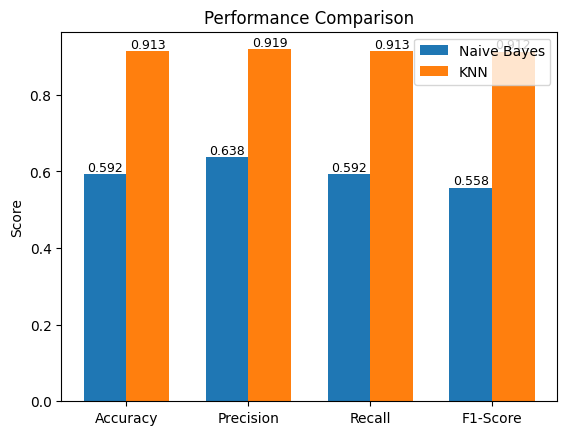

In [135]:
# Metrics
metrics = {
    "Accuracy": [
        accuracy_score(test_output, predicted2),
        accuracy_score(test_output, predicted)
    ],
    "Precision": [
        precision_score(test_output, predicted2, average="weighted"),
        precision_score(test_output, predicted, average="weighted")
    ],
    "Recall": [
        recall_score(test_output, predicted2, average="weighted"),
        recall_score(test_output, predicted, average="weighted")
    ],
    "F1-Score": [
        f1_score(test_output, predicted2, average="weighted"),
        f1_score(test_output, predicted, average="weighted")
    ]
}

# Get values of chart
labels = list(metrics.keys())
nb_scores = [metrics[m][0] for m in labels]
knn_scores = [metrics[m][1] for m in labels]

# Set vars for separate two bars
x = np.arange(len(labels))
width = 0.35

# Create chart and set parameter
plt.figure()
bars_nb = plt.bar(x - width/2, nb_scores, width, label="Naive Bayes")
bars_knn = plt.bar(x + width/2, knn_scores, width, label="KNN")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Performance Comparison")
plt.legend()

# Function to add data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

# Add labels to both models
add_labels(bars_nb)
add_labels(bars_knn)

# Display figure
plt.show()

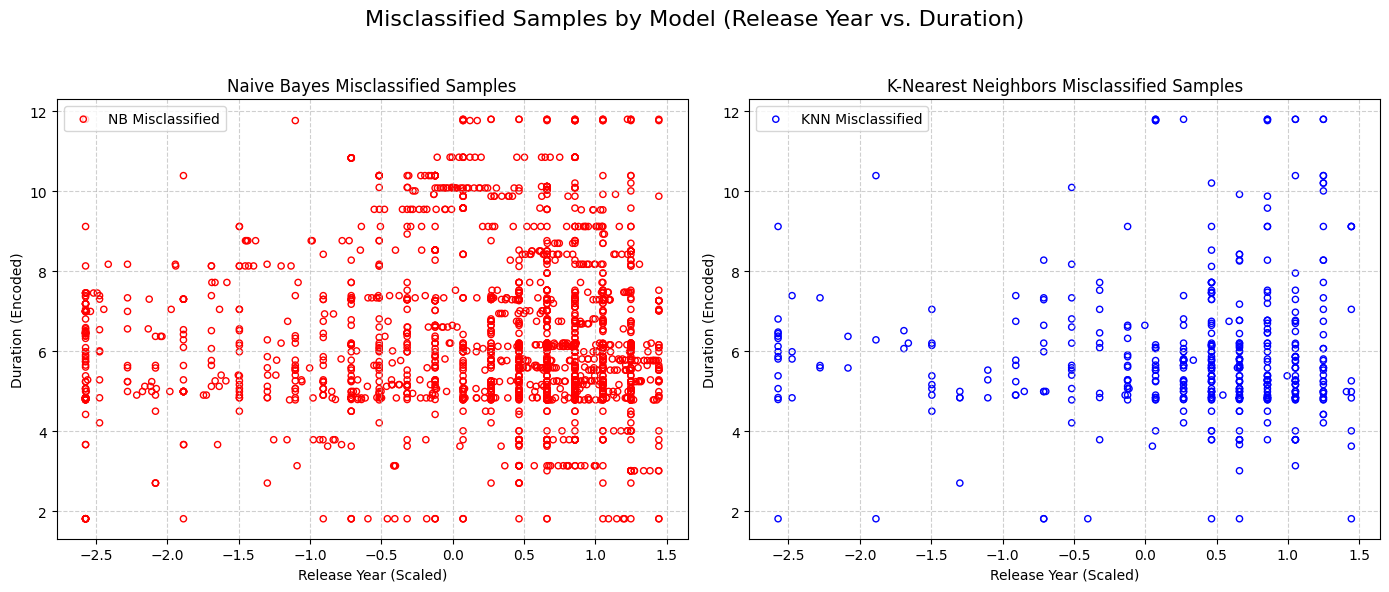

In [ ]:
# Identify misclassified samples
mis_nb = test_output != predicted2
mis_knn = test_output != predicted

# Set options for multiple charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Misclassified Samples by Model (Release Year vs. Duration)", fontsize=16)

# Naive Bayes misclassified
ax1 = axes[0]
ax1.scatter(
    test_input.loc[mis_nb, test_input.columns[5]],
    test_input.loc[mis_nb, test_input.columns[6]],
    marker="o",
    facecolors="none",
    color="red",
    label="NB Misclassified",
    s=20  # Size of points
)
ax1.set_xlabel("Release Year (Scaled)")
ax1.set_ylabel("Duration (Encoded)")
ax1.set_title("Naive Bayes Misclassified Samples")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# KNN misclassified
ax2 = axes[1]
ax2.scatter(
    test_input.loc[mis_knn, test_input.columns[5]],
    test_input.loc[mis_knn, test_input.columns[6]],
    marker="o",
    facecolors="none",
    edgecolors="blue",
    label="KNN Misclassified",
    s=20 # Point size
)
ax2.set_xlabel("Release Year (Scaled)")
ax2.set_ylabel("Duration (Encoded)")
ax2.set_title("K-Nearest Neighbors Misclassified Samples")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Display charts
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


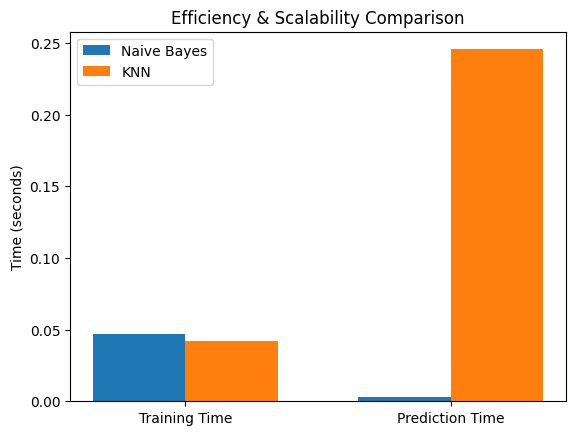

In [144]:
# Measure time
def measure_time(model, train_input, train_output, test_input):
    start = time.time()
    model.fit(train_input, train_output)
    train_time = time.time() - start

    start = time.time()
    model.predict(test_input)
    predict_time = time.time() - start

    return train_time, predict_time

# Get times
nb_train, nb_predict = measure_time(GaussianNB(), train_input, train_output, test_input)
knn_train, knn_predict = measure_time(KNeighborsClassifier(n_neighbors=5),
                                    train_input, train_output, test_input)

# Parameter of bar chart 
labels = ["Training Time", "Prediction Time"]
nb_times = [nb_train, nb_predict]
knn_times = [knn_train, knn_predict]

# Set vars for separate two bars
x = np.arange(len(labels))
width = 0.35

# Create chart
plt.figure()
plt.bar(x - width/2, nb_times, width, label="Naive Bayes")
plt.bar(x + width/2, knn_times, width, label="KNN")
plt.xticks(x, labels)
plt.ylabel("Time (seconds)")
plt.title("Efficiency & Scalability Comparison")
plt.legend()

# Display chart
plt.show()


# ***KNN Implementation***

In [ ]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        # نحول لـ numpy ونتأكد إنها أرقام
        self.X_train = np.asarray(X, dtype=float)
        self.y_train = np.asarray(y)
    
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        X = np.asarray(X, dtype=float)  # برضه نحول test_input
        predictions = []
        
        for x_test in X:
            # حساب المسافات مع كل نقاط التدريب
            distances = [self.euclidean_distance(x_test, x_train) 
                        for x_train in self.X_train]
            
            # أقرب K جيران
            k_indices = np.argsort(distances)[:self.k]
            k_labels = [self.y_train[i] for i in k_indices]
            
            # التصويت للأكثر تكراراً
            label = Counter(k_labels).most_common(1)[0][0]
            predictions.append(label)
        
        return np.array(predictions)


In [ ]:
import numpy as np
from collections import Counter

class KNN:
    # Constractor
    def __init__(self, k=3):
        self.k = k
    
    # Fit into data
    def fit(self, X, y):
        # Convert data to numpy array
        self.X_train = np.asarray(X, dtype=float)
        self.y_train = np.asarray(y)
    
    def predict(self, X):
        # Convert data to numpy array
        X_test = np.asarray(X, dtype=float)
        
        # Calculate difference between two points
        diff = X_test[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]
        
        # Sum all differences
        sq_distances = np.sum(diff ** 2, axis=2)
        
        # Calculate distance
        distances = np.sqrt(sq_distances) 
        
        # Sort data using numpy argsort function and get nearest k point2
        k_indices = np.argsort(distances, axis=1)[:, :self.k]
        
        # Retrieves the labels of the k nearest neighbors for each test sample
        k_nearest_labels = self.y_train[k_indices]
        
        # Prepare empty array for storing prediction
        predictions = np.empty(X_test.shape[0], dtype=self.y_train.dtype)
        
        # Get class of test data using common class
        for i, labels in enumerate(k_nearest_labels):
            predictions[i] = Counter(labels).most_common(1)[0][0]
            
        return predictions

In [ ]:
knn = KNN(k=1)
knn.fit(train_input, train_output)

predicted_knn = knn.predict(test_input)

accuracy = np.mean(predicted_knn == test_output)
print("Accuracy:", accuracy)

Accuracy: 0.9130521289295662
